<a href="https://colab.research.google.com/github/terrence-ou/DL_Playground/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple AutoEncoder and Latent Space Visualization with PyTorch

## Preliminaries

In [19]:
import os
import random
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Project running on device: ", DEVICE)

Project running on device:  cuda


In [2]:
config = {
    "batch_size": 64,
    "epochs": 3,
    "lr": 5e-4,
}

labels = ["T-shirt/top", 
          "Trouser", 
          "Pullover", 
          "Dress", 
          "Coat", 
          "Sandla", 
          "Shirt", 
          "Sneaker", 
          "Bag", 
          "Ankle boot"]

## Loading FashionMNIST Dataset

In [3]:
def collate_fn(batch):
    
    process = transforms.Compose([
                transforms.ToTensor(),
                transforms.Pad([2])]
                )
    
    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)
    
    y = torch.LongTensor([data[1] for data in batch])
    return x, y

In [6]:
train_data = FashionMNIST("./MNIST_DATA", train=True, download=True)
valid_data = FashionMNIST("./MNIST_DATA", train=False, download=True)

train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)

Inspecting train data: 
Batch shape:  torch.Size([64, 1, 32, 32])


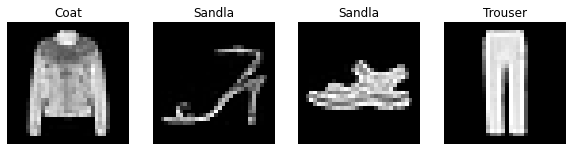

In [7]:
print("Inspecting train data: ")
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))
    for i in range(4):
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    break

## AutoEncoder

Here we implement a mirrored encoder-decoder model

In [8]:
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048

### Encoder

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()
        
        # bottleneck dimentionality
        self.output_dim = output_dim

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
    
        # convolutional layer hyper parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()
        
        # layers for latent space projection
        self.fc_dim = LINEAR_DIM
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.fc_dim, self.output_dim)
    
    
    def get_convs(self):
        """
        generating convolutional layers based on
        model's hyper parameters
        """
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            # The input channel of the first layer is 1
            if i == 0: conv_layers.append(nn.Conv2d(1, 
                                              self.channels[i], 
                                              kernel_size=self.kernels[i],
                                              stride=self.strides[i],
                                              padding=1))
            
            else: conv_layers.append(nn.Conv2d(self.channels[i-1], 
                                         self.channels[i],
                                         kernel_size=self.kernels[i],
                                         stride=self.strides[i],
                                         padding=1))
            
            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))
            
            conv_layers.append(nn.GELU()) # Here we use GELU as activation function
            
            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)

# Get the summary of autoencoder architecture
encoder = Encoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(encoder, (1, 32, 32))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              GELU-3           [-1, 32, 16, 16]               0
         Dropout2d-4           [-1, 32, 16, 16]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              GELU-7             [-1, 64, 8, 8]               0
         Dropout2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 4, 4]          73,856
      BatchNorm2d-10            [-1, 128, 4, 4]             256
             GELU-11            [-1, 128, 4, 4]               0
        Dropout2d-12            [-1, 128, 4, 4]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                   

### Decoder

In [10]:
class Decoder(nn.Module):
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        super(Decoder, self).__init__()
        
        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim
        
        # Conv layer hypyer parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES
        
        # In decoder, we first do fc project, then conv layers
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)
    

    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            
            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )
            
            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1], 
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )
            
            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        return self.output(x)
    
decoder = Decoder(use_batchnorm=True, use_dropout=True).to(DEVICE)
summary(decoder, (1, 2))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
       BatchNorm2d-3            [-1, 128, 8, 8]             256
              GELU-4            [-1, 128, 8, 8]               0
         Dropout2d-5            [-1, 128, 8, 8]               0
   ConvTranspose2d-6           [-1, 64, 16, 16]          73,792
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              GELU-8           [-1, 64, 16, 16]               0
         Dropout2d-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          18,464
             GELU-11           [-1, 32, 32, 32]               0
        Dropout2d-12           [-1, 32, 32, 32]               0
           Conv2d-13            [-1, 1, 32, 32]              33
Total params: 246,401
Trainable params:

### AutoEncoder

In [11]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=2, use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=2, use_batchnorm=True, use_dropout=False)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = AutoEncoder().to(DEVICE)
summary(model, (1, 32, 32))
pass

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              GELU-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              GELU-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              GELU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 2]           4,098
          Encoder-12                    [-1, 2]               0
           Linear-13                 [-1, 2048]           6,144
  ConvTranspose2d-14            [-1, 12

## Experiment

In [12]:
def plotting(step:int=0, show=False):
    
    model.eval() # Switch the model to evaluation mode
    
    points = []
    label_idcs = []
    
    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)
    
    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        # We only need to encode the validation images
        proj = model.encoder(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label
    
    points = np.array(points)
    
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0, 
                c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    if show: 
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else: 
        # Do not show but only save the plot in training
        plt.savefig(f"{path}/Step_{step:03d}.png", bbox_inches="tight")
        plt.close() # don't forget to close the plot, or it is always in memory
        model.train()

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)

# For mixed precision training
scaler = torch.cuda.amp.GradScaler()
steps = 0 # tracking the training steps

In [14]:
def train(model, dataloader, criterion, optimizer, save_distrib=False):
    # steps is used to track training progress, purely for latent space plots
    global steps 
    
    model.train()
    train_loss = 0.0
    
    # Process tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, 
                     leave=False, position=0, desc="Train")


    for i, batch in enumerate(dataloader):
        
        optimizer.zero_grad()
        x = batch[0].to(DEVICE)
        
        # Here we implement the mixed precision training
        with torch.cuda.amp.autocast():
            y_recons = model(x)
            loss = criterion(y_recons, x)
        
        train_loss += loss.item()
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        
        # Saving latent space plots
        if steps % 10 == 0 and save_distrib and steps <= 400: plotting(steps)
        
        
        batch_bar.update()
        steps += 1
        
        torch.cuda.empty_cache()
        del x, y_recons
    
    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss

In [15]:
def validate(model, dataloader, criterion):
    
    model.eval()
    valid_loss = 0.0
    
    # Progress tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")
    
    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)
        
        with torch.no_grad():
            y_recons = model(x)
            loss = criterion(y_recons, x)
        
        valid_loss += loss.item()
        
        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()
        
        torch.cuda.empty_cache()
        del x, y_recons
    
    batch_bar.close()
    valid_loss /= len(dataloader)
    
    return valid_loss

In [17]:
# Train the model
for i in range(config["epochs"]):
    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, criterion, optimizer, save_distrib=False) # Turn save_distrib = True if you wish animated latent space
    valid_loss = validate(model, valid_loader, criterion)
    print(f"Epoch {i+1}/{config['epochs']}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")
    

Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/3
Train loss: 0.0269	 Validation loss: 0.0247	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/3
Train loss: 0.0243	 Validation loss: 0.0234	lr: 0.0005


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/3
Train loss: 0.0232	 Validation loss: 0.0228	lr: 0.0005


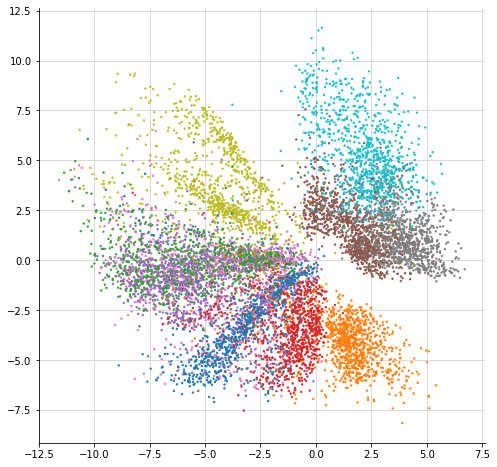

In [18]:
# Plotting the latent space
plotting(show=True)

In [195]:
# convert png images to gif
frames = []
imgs = sorted(os.listdir("./ScatterPlots"))

for im in imgs:
    new_frame = Image.open("./ScatterPlots/" + im)
    frames.append(new_frame)

frames[0].save("latentspace.gif", format="GIF",
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

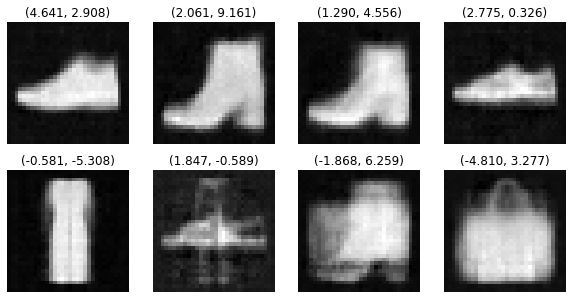

In [21]:
# randomly sample x and y values
xs = [random.uniform(-6.0, 8.0) for i in range(8)]
ys = [random.uniform(-7.5, 10.0) for i in range(8)]

points = list(zip(xs, ys))
coords = torch.tensor(points).unsqueeze(1).to(DEVICE)

nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

model.eval()
with torch.no_grad():
    generates = [model.decoder(coord) for coord in coords]

# plot points
idx = 0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax = axes[row, col]
        im = generates[idx].squeeze().detach().cpu()
        ax.imshow(im, cmap="gray")
        ax.axis("off")
        coord = coords[idx].detach().cpu().numpy()[0]
        ax.set_title(f"({coord[0]:.3f}, {coord[1]:.3f})")
        idx += 1
plt.show()
